In [1]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import math

import gc
import torch
import matplotlib.pyplot as plt
from einops import rearrange
from typing import Union, Dict, Optional
from torch import Tensor, nn
from torch.distributions import Categorical, Normal
from torch.nn import functional as F

from bliss.catalog import TileCatalog, get_images_in_tiles, get_is_on_from_n_sources
from bliss.reporting import DetectionMetrics
from case_studies.psf_homogenization.psf_decoder import PsfSampler, GalsimBlendswithPSF
from bliss.models.detection_encoder import (
    DetectionEncoder,
    LogBackgroundTransform,
    ConcatBackgroundTransform,
    EncoderCNN,
    make_enc_final,
)


# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

Modules to reload:
all-except-skipped

Modules to skip:

5


In [2]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])

In [3]:
def validation_step(self, batch, image_str):
    catalog_dict = {
        "locs": batch["locs"][:, :, :, 0 : self.max_detections],
        "log_fluxes": batch["log_fluxes"][:, :, :, 0 : self.max_detections],
        "galaxy_bools": batch["galaxy_bools"][:, :, :, 0 : self.max_detections],
        "n_sources": batch["n_sources"].clamp(max=self.max_detections),
    }
    true_tile_catalog = TileCatalog(self.tile_slen, catalog_dict)
    true_full_catalog = true_tile_catalog.to_full_params()
    image_ptiles = get_images_in_tiles(
        torch.cat((batch[image_str], batch["background"]), dim=1),
        self.tile_slen,
        self.ptile_slen,
    )
    image_ptiles = rearrange(image_ptiles, "n nth ntw b h w -> (n nth ntw) b h w")
    dist_params = self.encode(image_ptiles)
    est_catalog_dict = self.variational_mode(dist_params)
    est_tile_catalog = TileCatalog.from_flat_dict(
        true_tile_catalog.tile_slen,
        true_tile_catalog.n_tiles_h,
        true_tile_catalog.n_tiles_w,
        est_catalog_dict,
    )
    est_full_catalog = est_tile_catalog.to_full_params()

    metrics = self.val_detection_metrics(true_full_catalog, est_full_catalog)
    return metrics


In [4]:
from case_studies.psf_homogenization.galsim_blends_sg import GalsimBlendsSGwithPSF
prior = instantiate(cfg.datasets.galsim_blended_std_psf.prior) 
decoder = instantiate(cfg.datasets.galsim_blended_std_psf.decoder)
background = instantiate(cfg.datasets.galsim_blended_std_psf.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 10000
n_batches = 1
psf_sampler = PsfSampler(1.4, 1.4)

ds_psf = GalsimBlendsSGwithPSF(prior, decoder, background, tile_slen, max_tile_n_sources, num_workers=0, batch_size=10, n_batches=100, psf_sampler=psf_sampler, std_psf_fwhm=0.8, valid_n_batches=1)


In [5]:
DEVICE = "cuda:0"
PATH = "/home/wangchv/bliss/case_studies/psf_homogenization/output/sdss_detection_encoder_full_decoder_SG_std/version_0/checkpoints/epoch=979-val_loss=-0.299.ckpt"
detection_encoder_homo = instantiate(cfg.models.detection_encoder).eval()
model_checkpoint = torch.load(PATH, map_location=DEVICE)
model_state_dict = model_checkpoint["state_dict"]
detection_encoder_homo.load_state_dict(model_state_dict)
detection_encoder_homo = detection_encoder_homo.to(device)

In [7]:
DEVICE = "cuda:0"
PATH = "/home/wangchv/bliss/case_studies/psf_homogenization/output/sdss_detection_encoder_full_decoder_SG_rand/version_0/checkpoints/epoch=919-val_loss=-0.302.ckpt"
detection_encoder_unhomo = instantiate(cfg.models.detection_encoder).eval()
model_checkpoint = torch.load(PATH, map_location=DEVICE)
model_state_dict = model_checkpoint["state_dict"]
detection_encoder_unhomo.load_state_dict(model_state_dict)
#detection_encoder_unhomo = detection_encoder_unhomo.to(device) # transfer to GPU

<All keys matched successfully>

In [8]:
for x in ds_psf.val_dataloader():
    detection_encoder_homo_device = detection_encoder_homo.to(device)
    for key, _ in x.items():
        x[key] = x[key].to(device)
    print(validation_step(detection_encoder_homo_device, x, "images"))
    #print(validation_step(detection_encoder_unhomo, x, "noisy_image"))
    del detection_encoder_homo_device
    del x
    gc.collect()
    torch.cuda.empty_cache()

{'tp': tensor(17, device='cuda:0'), 'fp': tensor(36, device='cuda:0'), 'precision': tensor(0.3208, device='cuda:0'), 'recall': tensor(0.5862, device='cuda:0'), 'f1': tensor(0.4146, device='cuda:0'), 'avg_distance': tensor(2.9962, device='cuda:0', grad_fn=<DivBackward0>), 'n_galaxies_detected': tensor(0, device='cuda:0')}
{'tp': tensor(20, device='cuda:0'), 'fp': tensor(17, device='cuda:0'), 'precision': tensor(0.5405, device='cuda:0'), 'recall': tensor(0.6061, device='cuda:0'), 'f1': tensor(0.5714, device='cuda:0'), 'avg_distance': tensor(1.7804, device='cuda:0', grad_fn=<DivBackward0>), 'n_galaxies_detected': tensor(0, device='cuda:0')}
{'tp': tensor(25, device='cuda:0'), 'fp': tensor(25, device='cuda:0'), 'precision': tensor(0.5000, device='cuda:0'), 'recall': tensor(0.5952, device='cuda:0'), 'f1': tensor(0.5435, device='cuda:0'), 'avg_distance': tensor(4.5129, device='cuda:0', grad_fn=<DivBackward0>), 'n_galaxies_detected': tensor(0, device='cuda:0')}
{'tp': tensor(24, device='cuda:

RuntimeError: CUDA out of memory. Tried to allocate 42.00 MiB (GPU 0; 10.76 GiB total capacity; 9.24 GiB already allocated; 32.56 MiB free; 9.70 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

0.5


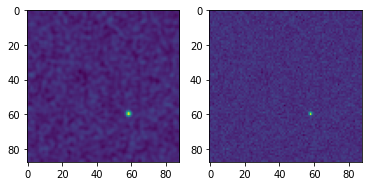

0.6


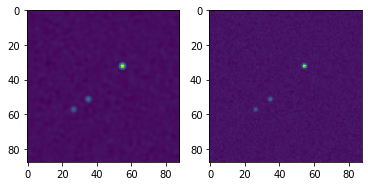

0.7


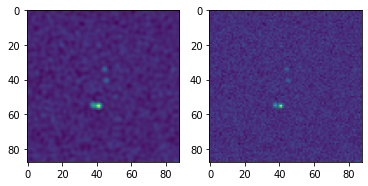

0.8


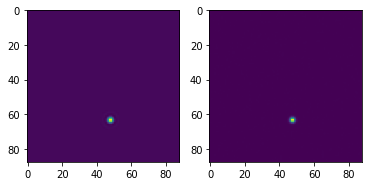

0.9


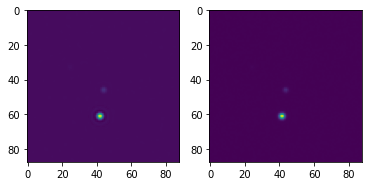

1.0


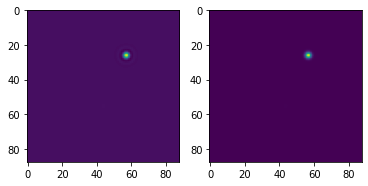

1.1


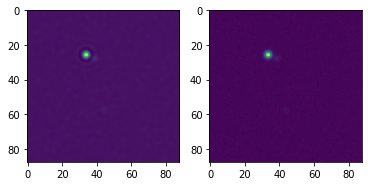

1.2000000000000002


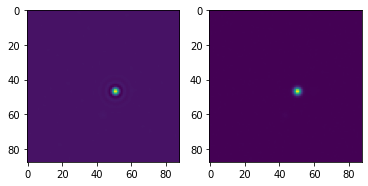

1.3


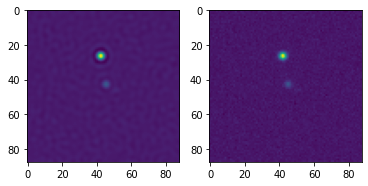

1.4


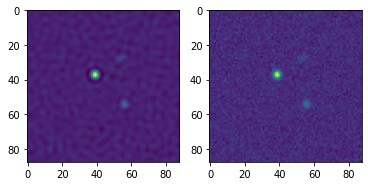

1.5


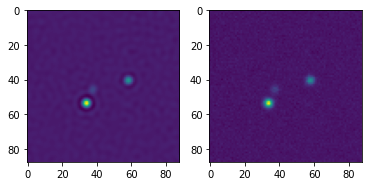

In [19]:
#generate images
for i in range(11):
    t = 0.5 + 0.1 * i
    psf_sampler = PsfSampler(t, t)
    ds_psf = GalsimBlendsSGwithPSF(prior, decoder, background, tile_slen, max_tile_n_sources, num_workers=0, batch_size=5, n_batches=1, psf_sampler=psf_sampler, std_psf_fwhm=0.8, valid_n_batches=1)
    
    for x in ds_psf.val_dataloader():
        print(t)
        plt.figure()
        plt.subplot(121)
        plt.imshow(x['images'][0, 0].numpy()) # plot first figure of each batch.
        plt.subplot(122)
        plt.imshow(x['noisy_image'][0, 0].numpy())
        plt.show()
    plt.close()

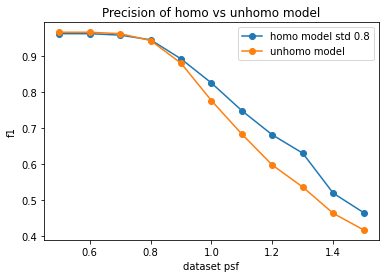

In [38]:
#draw plots
import matplotlib.pyplot as plt
import numpy as np
psfs = np.arange(0.5, 1.6, 0.1)
homo = np.array([0.963, 0.963, 0.959, 0.946, 0.893, 0.826, 0.749, 0.682, 0.631, 0.520, 0.466])
unhomo = np.array([0.967, 0.967, 0.963, 0.944, 0.881, 0.777, 0.684, 0.598, 0.537, 0.464, 0.418])
plt.plot(psfs, homo, "o-", label="homo model std 0.8")
plt.plot(psfs, unhomo, "o-", label="unhomo model")
plt.xlabel("dataset psf")
plt.ylabel("f1")
plt.legend()
plt.title("Precision of homo vs unhomo model")
plt.show()

TypeError: 'float' object cannot be interpreted as an integer